Objectives

Business Question  - The client is interested in determining whether a particular leaf is infected or not.

Inputs

split_data/train
split_data/test
split_data/validation
created image embeddings

Outputs



In [3]:
%pip install keras scipy



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Import packages

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

Set Directory

In [5]:
cwd= os.getcwd()

In [6]:
os.chdir('/workspace/project5-mildrew')
print("You set a new current directory")

You set a new current directory


In [7]:
work_dir = os.getcwd()
work_dir

'/workspace/project5-mildrew'

Set Input Directories

In [8]:
my_data_dir = 'split_data'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Reset Output Directory

In [9]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


Set the label to train images

In [10]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


Get Image Shape from the previous data visualisation output

In [11]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

Plot the number of images in the train, validation and test sections

* train - healthy: 1261 images
* train - powdery_mildew: 1262 images
* validation - healthy: 420 images
* validation - powdery_mildew: 420 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


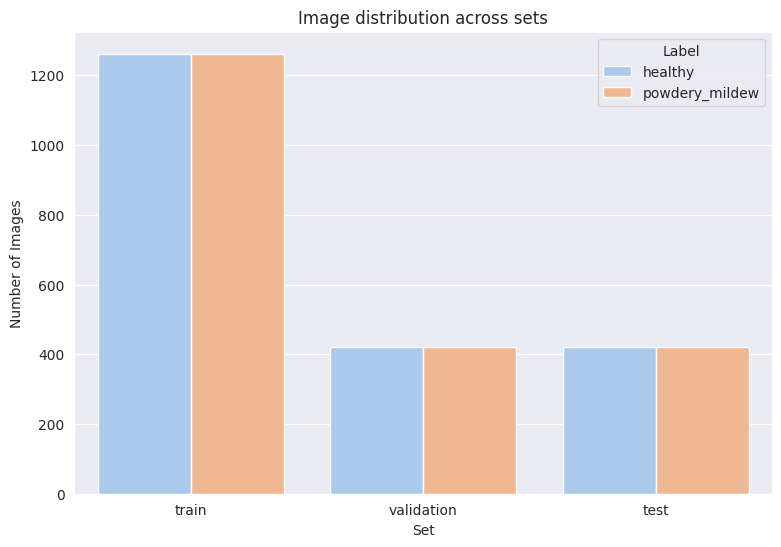

In [12]:
data = []
for folder in ['train', 'validation', 'test']:
    for label in labels:
        frequency = int(len(os.listdir(os.path.join(my_data_dir, folder, label))))
        data.append({'Set': folder, 'Label': label, 'Frequency': frequency})
        print(f"* {folder} - {label}: {frequency} images")

# Create dataframe
df_freq = pd.DataFrame(data)

# Plot number of images in each section
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette='pastel')
plt.title('Image distribution across sets')
plt.ylabel('Number of Images')
plt.savefig(os.path.join(file_path, 'labels_distribution.png'), bbox_inches='tight', dpi=150)
plt.show()



Image Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-05 23:17:14.004101: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 23:17:14.044614: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 23:17:14.045494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 23:17:14.965223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Set Augmentation Parameters

In [14]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Apply augmentations on training image set

In [15]:
batch_size = 10
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=(75, 75),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2523 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Apply augmentations on validation image set

In [16]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=(75, 75),
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 840 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Apply augmentations on test image set

In [17]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=(75, 75),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot Augmented Images (Validation & Test Set)

(10, 75, 75, 3)


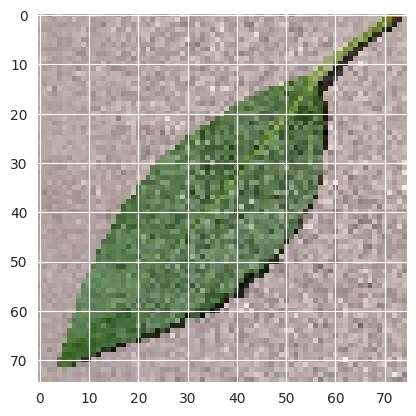

(10, 75, 75, 3)


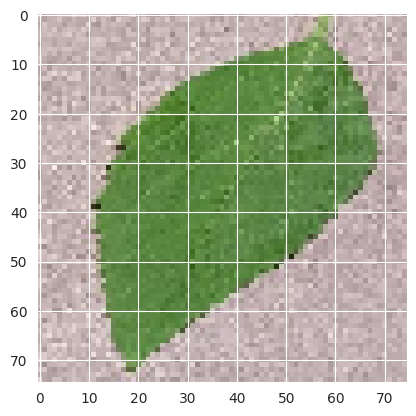

(10, 75, 75, 3)


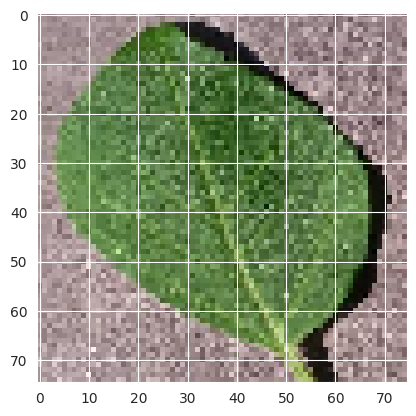

In [18]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(10, 75, 75, 3)


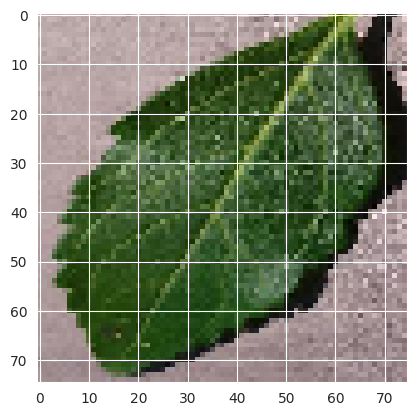

(10, 75, 75, 3)


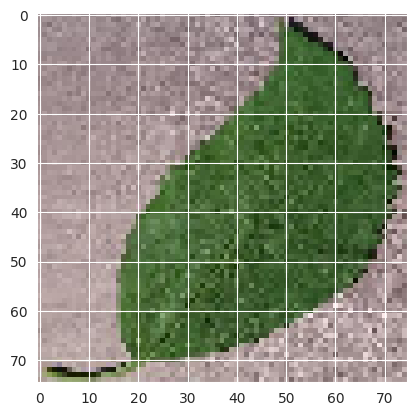

(10, 75, 75, 3)


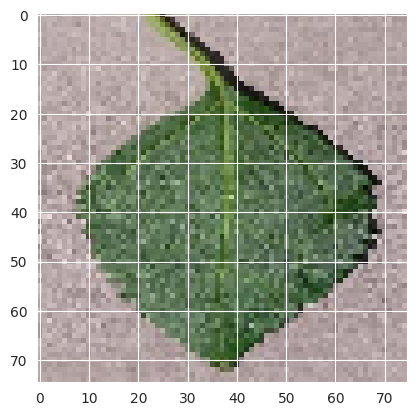

In [19]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Save class indices

In [20]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

Machine Learning Model

Import packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

ML model

In [23]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(75, 75, 3), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

summary

In [24]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0

Early Stop

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=4)

fit model

In [26]:
model = create_tf_model()
model.fit(train_set,
          epochs=15,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/15
252/252 [==============================] - 12s 46ms/step - loss: 0.4119 - accuracy: 0.7947 - val_loss: 0.1029 - val_accuracy: 0.9512
Epoch 2/15
252/252 [==============================] - 9s 35ms/step - loss: 0.1309 - accuracy: 0.9558 - val_loss: 0.0223 - val_accuracy: 0.9940
Epoch 3/15
252/252 [==============================] - 9s 34ms/step - loss: 0.0729 - accuracy: 0.9741 - val_loss: 0.0224 - val_accuracy: 0.9929
Epoch 4/15
252/252 [==============================] - 9s 35ms/step - loss: 0.0570 - accuracy: 0.9833 - val_loss: 0.0154 - val_accuracy: 0.9929
Epoch 5/15
252/252 [==============================] - 9s 34ms/step - loss: 0.0414 - accuracy: 0.9904 - val_loss: 0.0069 - val_accuracy: 0.9964
Epoch 6/15
252/252 [==============================] - 9s 34ms/step - loss: 0.0503 - accuracy: 0.9853 - val_loss: 0.0097 - val_accuracy: 0.9964
Epoch 7/15
252/252 [==============================] - 9s 34ms/step - loss: 0.0659 - accuracy: 0.9837 - val_loss: 0.0974 - val_accuracy: 0.976

In [27]:
model.save('outputs/v1/mildew_detector_model.h5')

/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
